## Importing Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import random
import time
from collections import deque
import gym
import time

import tensorflow.compat.v1 as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/Users/emtiazsamad/opt/anaconda3/envs/datascience/bin/ffmpeg'
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import HTML, clear_output

tf.disable_v2_behavior()

/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:597: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/framework/dtypes.py:605: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/Users/emtiazsamad/opt/anaconda3/envs/datascience/

Instructions for updating:
non-resource variables are not supported in the long term


## Implementing DDQN (Double DQN) Algorithm with Experience Replay

In [2]:
def network(opt, input_dim, action_size):
    network = Sequential()
    network.add(Dense(128, input_dim = input_dim, activation = "relu"))
    network.add(Dense(128, activation = "relu"))
    network.add(Dense(action_size, activation = "linear"))
    network.compile(optimizer = opt, loss = 'mse')
    return network

class DDQNAgent:
    def __init__(self, env, optimizer, batch_size, gamma=0.99, epsilon=1, decay=0.995):
        self.env = env
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
        self.exp_replay = deque(maxlen=1000000)
        
        self.qnetwork = network(self.optimizer, self.state_size, self.action_size)
        self.target = network(self.optimizer, self.state_size, self.action_size)
        
        self.rewards = None
        self.average_reward = None
        self.time = []

    def policy(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_size)
        else:
            state = np.reshape(state, [1, self.state_size])
            actions = self.qnetwork.predict(state)
            action = np.argmax(actions[0])
        return action
    
    def add_memory(self, state, action, reward, next_state, terminal):
        self.exp_replay.append((state, action, reward, next_state, terminal))
    
    def update_target(self):
        return self.target.set_weights(self.qnetwork.get_weights())
    
    def train(self):
        batch_size = min(len(self.exp_replay), self.batch_size)
        batch = random.sample(self.exp_replay, batch_size)
        
        states = np.ndarray((batch_size, self.state_size))
        next_states = states.copy()
        
        actions = np.ndarray((batch_size, 1))
        rewards = actions.copy()
        terminals = actions.copy()
        
        step = 0
        for memory in batch:
            states[step], actions[step], rewards[step], next_states[step], terminals[step] = memory
            step += 1
         
        q_next = self.target.predict(next_states) * (np.ones(shape = terminals.shape) - terminals)
        q_next = np.max(q_next, axis=1)
        q = self.qnetwork.predict(states)
        
        for i in range(batch_size):
            q[i,int(actions[i,0])] = rewards[i] + self.gamma * q_next[i]
            
        self.qnetwork.fit(states, q, verbose = 0)
    
    def train_model(self, env, num_episodes):
        count = 0
        rewards, average_reward = [], []
        average = deque(maxlen=100)
        
        txt = open('Saved Networks.txt', 'w')
        path = os.getcwd() + '/Saved Networks'
        if not os.path.exists(path):
            os.makedirs(path)
        
        start = time.time()
        
        for episode in range(1, num_episodes + 1):
            state = env.reset()
            total = 0
            terminal = False
            
            while not terminal:
                action = self.policy(state)
                next_state, reward, terminal, _ = env.step(action)
                
                total += reward
                
                self.add_memory(state, action, reward, next_state, terminal)
                self.train()
                state = next_state
        
            average.append(total)
            average_reward.append(np.mean(average))
            rewards.append(total)

            self.update_target()
            self.epsilon = max(0.1, self.decay * self.epsilon)
            end = time.time()
            self.time.append(end - start)
            print(f'Episode {episode}: {total}')
            
            if episode % 100 == 0:
                self.qnetwork.save(('Saved Networks/ddqn_model_{0}'.format(count)))
                txt.write("Save {0} - Episode {1}, Reward: {2}, Average Reward: {3}\n".format(count, 
                                                                                          episode, 
                                                                                          total, 
                                                                                          np.mean(average)))
                count += 1

        self.rewards = rewards
        self.average_reward = average_reward
        
    def test_model(self, env, num_episodes, file):
        self.qnetwork = tf.keras.models.load_model(file)
        self.epsilon = 0
        
        count = 0
        rewards, average_reward, all_eps_frames = [], [], []
        average = deque(maxlen=100)
        eps_frames = None
        
        for episode in range(1, num_episodes + 1):
            state = env.reset()
            total = 0
            eps_frames = []
            terminal = False
            
            while not terminal:
                env.render()
                action = self.policy(state)
                next_state, reward, terminal, _ = env.step(action)
                
                if eps_frames is not None:
                    eps_frames.append(env.render(mode='rgb_array'))
                
                total += reward                
                state = next_state
                
                if terminal:
                    if eps_frames is not None:
                        all_eps_frames.append(eps_frames)
            
            average.append(total)
            average_reward.append(np.mean(average))
            rewards.append(total)
            print(f'Episode {episode}: {total}')
        
        self.rewards = rewards
        self.average_reward = average_reward
        
        return all_eps_frames
        
    def plot_results(self):
        plt.figure(figsize = (10, 6), dpi = 100)

        plt.plot(self.rewards, alpha = 0.7, label = 'Rewards')
        plt.plot(self.average_reward, 'red', label = 'Average Rewards')
        plt.axhline(y = 200, color = 'orange', linestyle = '-', label = 'Threshold')
        
        plt.xlim(0, len(self.rewards))
        plt.title('Learning Curve', fontweight = 'bold')
        plt.xlabel('Episode', fontweight = 'bold')
        plt.ylabel('Reward', fontweight = 'bold')
        plt.legend(loc = 'lower right')

In [18]:
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)
agent = DDQNAgent(env, optimizer, batch_size = 64)
agent.train_model(env, num_episodes=10)

/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Episode 1: -105.6949463822307
Episode 2: -127.83712104841115
Episode 3: -205.93879599400614
Episode 4: -194.15425084023335
Episode 5: -123.94905767826587
Episode 6: -311.38712157989494
Episode 7: -239.57245442954607
Episode 8: -55.03186990923318
Episode 9: -36.68446778594338
Episode 10: -293.41667384162895


## Storing Rewards per Episode in DataFrame and Saving as CSV File

In [3]:
'''RUN CELL AND UNCOMMENT LAST LINE IF MODEL HAS BEEN TRAINED, OTHERWISE IGNORE'''
df = pd.DataFrame()
df['Reward'] = agent.rewards
df['Average Reward'] = agent.average_reward
df['Time'] = agent.time
#df.to_csv('DDQN Rewards.csv')

NameError: name 'agent' is not defined

## Reloading Instance with Saved Rewards and Plotting Train Results

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:1293: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(sample_weight_mode, collections.Mapping):


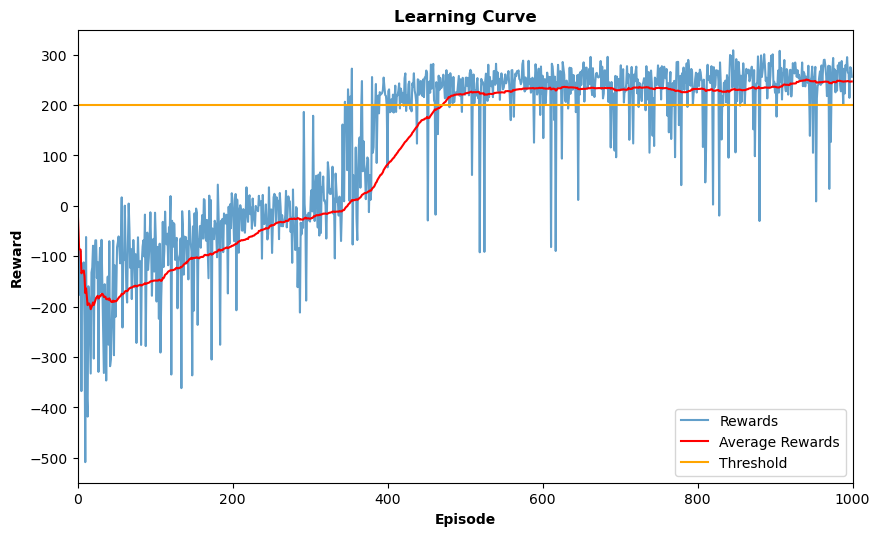

In [4]:
df = pd.read_csv('DDQN Rewards.csv')
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)

agent_plt = DDQNAgent(env, optimizer, batch_size = 64)
agent_plt.rewards = df['Reward']
agent_plt.average_reward = df['Average Reward']
agent_plt.plot_results()

## Testing Models and Recording Performance at Varying Number of Episodes Trained
- Tests performed at 100, 500 and 1000 episodes trained

In [5]:
def render(episode, env, m_name, n_ep):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,
    
    mp4 = os.getcwd() + '/' + str(m_name) + ' Videos/' + str(m_name) + '_' + str(n_ep) +'.mp4'
    anim = FuncAnimation(fig, animate, frames=len(episode), interval=1, blit=True)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps = 50, metadata = dict(artist = 'Me'), bitrate = 1800)
    anim.save(mp4, writer = writer, dpi=100)

    html =  HTML(anim.to_html5_video())

    plt.close(fig)
    
    return html

def save_video(episodes_frames, methods, env):
    path = os.getcwd() + '/' + methods + ' Videos'
    if not os.path.exists(path):
        os.makedirs(path)
        
    for i in range(len(episodes_frames)):
        render(episodes_frames[i], env, methods, i)

In [6]:
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)

for i in range(10):
    agent_test = DDQNAgent(env, optimizer, batch_size = 64)
    print(f'\n{(i+1)*100} Episodes Trained')
    agent_test.test_model(env, 1, 'Saved Networks/ddqn_model_{}'.format(i))



100 Episodes Trained
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-05-06 12:06:30.942173: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 12:06:30.943117: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
/Users/emtiazsamad/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Episode 1: -418.9312353203256

200 Episodes Trained
Episode 1: -61.41068810572493

300 Episodes Trained


KeyboardInterrupt: 

In [8]:
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = 0.0001)

episodes_ddqn = []

agent_test = DDQNAgent(env, optimizer, batch_size = 64)
print('300 Episodes Trained')
test = agent_test.test_model(env, 3, 'Saved Networks/ddqn_model_4')

episodes_clip = []
for i in range(3):
    episodes_clip += test[i]
episodes_ddqn.append(episodes_clip)

300 Episodes Trained
Episode 1: 112.51566497865755
Episode 2: 208.45679606316963
Episode 3: 179.80650267934132


In [9]:
save_video(episodes_ddqn, 'DDQN', env)

## Plotting Test Results

Episode 1: 261.54694064175374
Episode 2: 287.96016407963
Episode 3: 276.7577862783005
Episode 4: 237.84947805264318
Episode 5: 226.10832168127257
Episode 6: 253.92059634540536
Episode 7: 269.7692064477245
Episode 8: 270.20107216258197
Episode 9: 233.3542546020434
Episode 10: 144.1557718314241
Episode 11: 250.52875789778264
Episode 12: 287.73615763220914
Episode 13: 268.75988213494054
Episode 14: 273.73997868034394
Episode 15: 139.25782444732516
Episode 16: 249.0471427101404
Episode 17: 255.61012123241338
Episode 18: 200.86048626651842
Episode 19: 233.7531435493618
Episode 20: 256.5803017070325
Episode 21: 282.3381646398261
Episode 22: 275.6319338531229
Episode 23: 251.87178802720888
Episode 24: 243.259798230563
Episode 25: 271.5075021140634
Episode 26: 290.41942607190015
Episode 27: 268.3871892048694
Episode 28: 235.15601592701313
Episode 29: 259.40924192884427
Episode 30: 225.5947504678309
Episode 31: 255.50026552416296
Episode 32: 137.6056490381219
Episode 33: 252.66253814474908
Epis

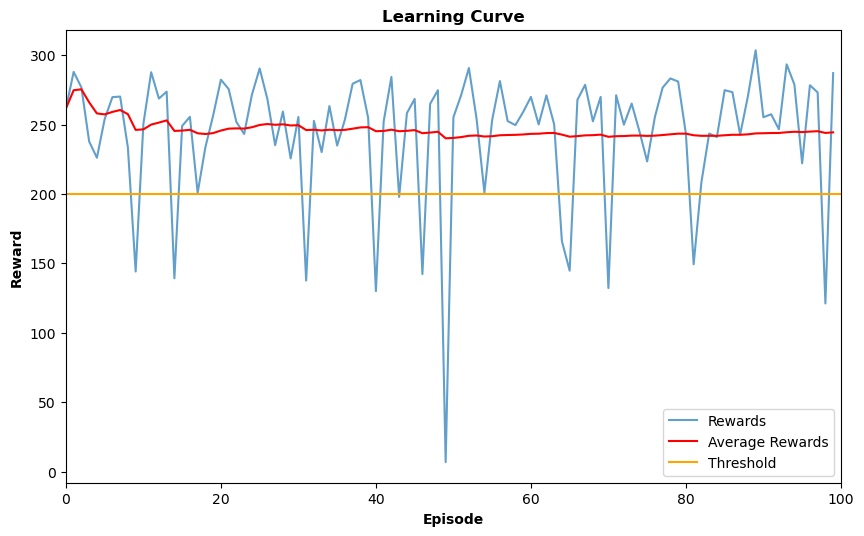

In [13]:
agent_test = DDQNAgent(env, optimizer, batch_size = 64)
agent_test.test_model(env, 100, 'Saved Networks/ddqn_model_{}'.format(9))
agent_test.plot_results()